# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

### Инструкция по выполнению проекта
1. Загрузите и подготовьте данные. Поясните порядок действий.
2. Обучите и проверьте модель для каждого региона:
    1. Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.
    2. Обучите модель и сделайте предсказания на валидационной выборке.
    2. Сохраните предсказания и правильные ответы на валидационной выборке.
    2. Напечатайте на экране средний запас предсказанного сырья и RMSE модели.
    2. Проанализируйте результаты.
3. Подготовьтесь к расчёту прибыли:
    1. Все ключевые значения для расчётов сохраните в отдельных переменных.
    2. Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе.
    3. Напишите выводы по этапу подготовки расчёта прибыли.
4. Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
    1. Выберите скважины с максимальными значениями предсказаний.
    2. Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
    3. Рассчитайте прибыль для полученного объёма сырья.
5. Посчитайте риски и прибыль для каждого региона:
    1. Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
    2. Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
    3. Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.

### Описание данных
Данные геологоразведки трёх регионов:
* id — уникальный идентификатор скважины;
* f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
* product — объём запасов в скважине (тыс. баррелей).

### Условия задачи:
* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
* Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

### Импорт библиотек

In [1]:
!pip install sweetviz -q
!pip install pandas_profiling==1.4.1 -q
!pip install pandas==0.25.3 -q
!pip install -U scikit-learn -q
#!pip install -U matplotlib

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None
import pandas_profiling
from pandas_profiling import ProfileReport
import numpy as np
from numpy.random import RandomState
from scipy import stats as st 

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score

In [3]:
import matplotlib.pyplot as plt
#from matplotlib import cm
%matplotlib inline

### Загрузка датасетов

In [4]:
for i in range(3):
    
    try:
        globals()['geo_data_' + str(i)] = pd.read_csv('/datasets/geo_data_' + str(i) + '.csv')
    except:
        globals()['geo_data_' + str(i)] = pd.read_csv('F:/geo_data_' + str(i) + '.csv')

In [5]:
pandas_profiling.ProfileReport(geo_data_0)

/home/jovyan/.local/lib/python3.7/site-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,5
Number of observations,100000
Total Missing (%),0.0%
Total size in memory,3.8 MiB
Average record size in memory,40.0 B
Numeric,4
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,0


/home/jovyan/.local/lib/python3.7/site-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,5
Number of observations,100000
Total Missing (%),0.0%
Total size in memory,3.8 MiB
Average record size in memory,40.0 B
Numeric,3
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,1

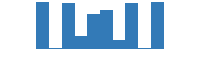

In [6]:
pandas_profiling.ProfileReport(geo_data_1)

In [7]:
pandas_profiling.ProfileReport(geo_data_2)

/home/jovyan/.local/lib/python3.7/site-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,5
Number of observations,100000
Total Missing (%),0.0%
Total size in memory,3.8 MiB
Average record size in memory,40.0 B
Numeric,4
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,0


### Выводы

Данные подготовлены, пропусков и дубликатов не обнаружено, типы данных и названия колонок соответствующие.

Корреляция между признаками довольно слабая, что дает нам право на обучение модели на их основе. Во втором регионе наблюдаем сильную прямую зависимость целевого признака от признака f2. Так как столбцы id содержат идентификаторы скважин, то эти данные никак не влияют на целевой признак и поэтому в расчет не принимаются.

## Обучение и проверка модели

 Разобъем данные на обучающую и валидационную выборки в соотношении 75:25

In [8]:
# функция деления данных

def data_split(geo_data):
    
    X = geo_data[['f0', 'f1', 'f2']]
    y = geo_data['product']
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=12345)
    print (X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)
    
    return X_train, X_valid, y_train, y_valid

In [9]:
# Деление данных для 3-х регионов и проверка правильности разбиения

i = 0

for geo_data in [geo_data_0, geo_data_1, geo_data_2]:
    
    globals()['X_train_' + str(i)], globals()['X_valid_' + str(i)], \
    globals()['y_train_' + str(i)], globals()['y_valid_' + str(i)] = data_split(geo_data)
    i += 1

(75000, 3) (75000,) (25000, 3) (25000,)
(75000, 3) (75000,) (25000, 3) (25000,)
(75000, 3) (75000,) (25000, 3) (25000,)


Функция обучения моделей линейной регрессии и получения метрик их качества, сохранения предсказаний и целевого признака

In [10]:
def model_learning (X_train, X_valid, y_train, y_valid):
    
    # Введение модели линейной регрессии 
    model = LinearRegression()
    
    # Кросс-валидация с разбиением на 5 фолдов, получение метрики качества (R2) для каждой из них 
    scores = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1)
    print ('R2 региона на кросс-валидации:', scores)
    
    # Среднее значение метрики и стандартное отклонение
    print (f'Средний R2 на кросс-валидации: {np.mean(scores):.5f} std: {np.std(scores):.5f}') 
    
    # Получение предсказаний и их проверка кросс-валидацией
    predictions = cross_val_predict(model, X_valid, y_valid, cv=5)
    
    # Аccuracy-метрика для предсказаний на лучшем фолде кросс-валидации
    print (f'Лучший R2: {r2_score(y_valid, predictions):.4f}')
    
    # RMSE для предсказаний на лучшем фолде кросс-валидации
    print (f'RMSE: {mean_squared_error(y_valid, predictions, squared=False):.2f}')
    
    # Обучение модели
    model.fit(X_train, y_train)
    
    # Предсказания и правильные ответы на валидационной выборке
    y_predict = model.predict(X_valid)
    y_valid = y_valid.reset_index(drop=True)
    print (F'Предсказанный средний запас: {y_predict.mean():.2f}')
    print (F'Истинный средний запас: {y_valid.mean():.2f}')
    
    return y_predict, y_valid

Получение данных по качеству моделей, предсказанного и истинного запаса

In [11]:
print ('Качество модели для 1 региона: \n')
y_predict_0, y_valid_0 = model_learning(X_train_0, X_valid_0, y_train_0, y_valid_0)

Качество модели для 1 региона: 

R2 региона на кросс-валидации: [0.26543147 0.27779784 0.28135147 0.27476308 0.27108881]
Средний R2 на кросс-валидации: 0.27409 std: 0.00549
Лучший R2: 0.2801
RMSE: 37.57
Предсказанный средний запас: 92.59
Истинный средний запас: 92.08


In [12]:
print ('Качество модели для 2 региона: \n')
y_predict_1, y_valid_1 = model_learning(X_train_1, X_valid_1, y_train_1, y_valid_1)

Качество модели для 2 региона: 

R2 региона на кросс-валидации: [0.99963474 0.99962007 0.99962403 0.99962336 0.99962121]
Средний R2 на кросс-валидации: 0.99962 std: 0.00001
Лучший R2: 0.9996
RMSE: 0.89
Предсказанный средний запас: 68.73
Истинный средний запас: 68.72


In [13]:
print ('Качество модели для 3 региона: \n')
y_predict_2, y_valid_2 = model_learning(X_train_2, X_valid_2, y_train_2, y_valid_2)

Качество модели для 3 региона: 

R2 региона на кросс-валидации: [0.19754075 0.19883786 0.19447795 0.19719633 0.19435838]
Средний R2 на кросс-валидации: 0.19648 std: 0.00177
Лучший R2: 0.2052
RMSE: 40.03
Предсказанный средний запас: 94.97
Истинный средний запас: 94.88


### Выводы

* Данные разбиты на обучающую и валидационную выборки в соотношении 75:25.
* Модели обучены, предсказания на валидационной выборке сделаны.
* Предсказания и правильные ответы на валидационной выборке сохранены.
* Средний запас предсказанного сырья и RMSE моделей выведены на экран.
* Модели показали хорошие результаты, особенно для 2-го региона, где признак f2 сильно коррелирует с целевым.

## Подготовка к расчёту прибыли

Условия задачи:

* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* Доход с каждой единицы продукта составляет 450 тыс. рублей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5% (другими словами - вероятность получить 10 млрд рублей дохода с 200 лучших больше 95%, так как распределение двухстороннее). Среди них выбрать регион с наибольшей средней прибылью.

Для всех ключевых значений создадим константы

In [14]:
BUDGET = 10000000000
BEST_LOC_NUM = 200
LOC_NUM = 500
PRODUCT_UNIT_INCOME = 450000
ALPHA = 0.025
BOOTSTRAP_SAMPLES = 1000

Посчитаем минимальное среднее количество продукта в месторождениях региона, достаточное для разработки

In [15]:
min_mean_product = BUDGET / BEST_LOC_NUM / PRODUCT_UNIT_INCOME
min_mean_product

111.11111111111111

Следовательно нам нужно выбрать такие регионы, чтобы у 200 лучших скважин по объему сырья среднее его количество было не меньше найденного с заявленной вероятностью чтобы гарантированно окупить бюджет

Напишем функцию расчёта прибыли

In [16]:
def profit(y_predict_sample, y_valid):
         
    y_predict_sample_best_200 = y_predict_sample.sort_values(ascending=False)[:BEST_LOC_NUM]
    sample_profit = y_valid[y_predict_sample_best_200.index].sum() * PRODUCT_UNIT_INCOME - BUDGET
    
    return sample_profit

### Выводы

* Для всех ключевых значений созданы константы
* Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
* Сделан вывод о необходимости выбора таких регионов, чтобы у 200 лучших скважин по объему сырья среднее его количество было не меньше найденного с заявленной вероятностью, чтобы гарантированно окупить бюджет
* Написана функция расчёта прибыли

## Расчёт прибыли и рисков 

Проведем процедуру Bootstrap и найдем распределения значений суммарного дохода лучших 200 скважин для 1000 случайных выборок по 500 

In [17]:
# Функция подсчета суммарной прибыли лучших 200 скважин из 500 для 1000 случайных выборок 

def sample_profit_dist(y_predict, y_valid):
    
    state = RandomState(12345)
    sample_profit_distrib = []
    count = 0      # счетчик числа убыточных выборок
    
    for i in range(BOOTSTRAP_SAMPLES):    
        
        # Bootstrap
        y_predict_sample = pd.Series(y_predict).sample(n=LOC_NUM, replace=True, random_state=state)
        
        # Подсчет прибыли для выборки
        sample_profit = profit(y_predict_sample, y_valid)
        
        # Создание распределения значений прибыли выборок
        sample_profit_distrib.append(sample_profit)
        
        # Подсчет убыточных выборок
        if sample_profit < 0:
            count += 1
    
    return pd.Series(sample_profit_distrib), count

Получение распределений выборок прибыли по регионам

In [18]:
sample_profit_dist_0, count_0 = sample_profit_dist(y_predict_0, y_valid_0)
sample_profit_dist_1, count_1 = sample_profit_dist(y_predict_1, y_valid_1)
sample_profit_dist_2, count_2 = sample_profit_dist(y_predict_2, y_valid_2)

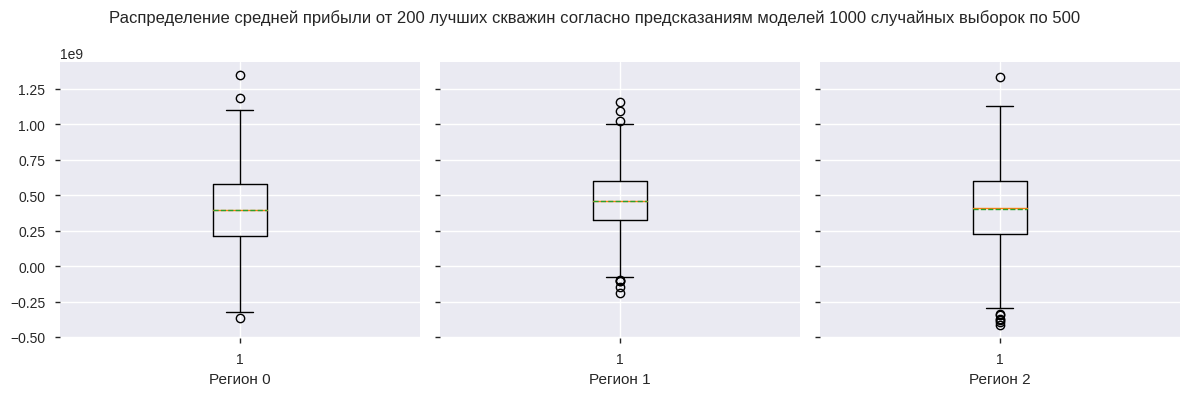

In [19]:
# Коробчатые диаграммы распределений прибыли по регионам

fig, ax = plt.subplots(1, 3, figsize=(12,4), sharey=True, tight_layout=True)
fig.suptitle('Распределение средней прибыли от 200 лучших скважин согласно предсказаниям моделей 1000 случайных выборок по 500')

i = 0
for sample_profit_dist in [sample_profit_dist_0, sample_profit_dist_1, sample_profit_dist_2]:

    ax[i].boxplot(sample_profit_dist, meanline=True, showmeans=True, showcaps=True, showbox=True, showfliers=True)
    ax[i].set(xlabel='Регион ' + str(i))
    i +=1

#plt.ylim(0, 10)
plt.show()

Функция получения показателей по регионам: средней прибыли, риска убытков и выводов

In [20]:
def result(profit, count):
    
    print (profit.describe(), '\n')
    print (f'Средняя прибыль: {profit.mean() / 1000000:.2f} млн руб.')
    #print ('95%-й доверительный интервал:', \
    #       st.t.interval(alpha=1-2*ALPHA, df=len(profit)-1, loc=profit.mean(), scale=np.std(profit, ddof=1)))
    
    print (f'95%-й доверительный интервал: {np.quantile(profit, 0.025):.0f}, {np.quantile(profit, 0.975):.0f}')
    
    # Расчет доли убыточных выборок
    p_value = 1. * count / BOOTSTRAP_SAMPLES
    
    if p_value < ALPHA:
        print(f'Вероятность убытков равна {p_value:.2%} и меньше допустимой - регион подойдет для разработки')
    else:
        print(f'Вероятность убытков равна {p_value:.2%} и больше допустимой - регион не подойдет для разработки')

Итоговые показатели прибыли 1000 случайных выборок по 500 в 3-х регионах

In [21]:
print ('Показатели региона 1: \n')
result(sample_profit_dist_0, count_0)

Показатели региона 1: 

count    1.000000e+03
mean     3.961650e+08
std      2.666143e+08
min     -3.695671e+08
25%      2.139204e+08
50%      3.950089e+08
75%      5.793003e+08
max      1.349267e+09
dtype: float64 

Средняя прибыль: 396.16 млн руб.
95%-й доверительный интервал: -111215546, 909766942
Вероятность убытков равна 6.90% и больше допустимой - регион не подойдет для разработки


In [22]:
print ('Показатели региона 2: \n')
result(sample_profit_dist_1, count_1)

Показатели региона 2: 

count    1.000000e+03
mean     4.560451e+08
std      2.078466e+08
min     -1.922681e+08
25%      3.250479e+08
50%      4.570359e+08
75%      5.989760e+08
max      1.154047e+09
dtype: float64 

Средняя прибыль: 456.05 млн руб.
95%-й доверительный интервал: 33820509, 852289454
Вероятность убытков равна 1.50% и меньше допустимой - регион подойдет для разработки


In [23]:
print ('Показатели региона 3: \n')
result(sample_profit_dist_2, count_2)

Показатели региона 3: 

count    1.000000e+03
mean     4.044039e+08
std      2.732762e+08
min     -4.178570e+08
25%      2.281472e+08
50%      4.072058e+08
75%      6.019454e+08
max      1.330593e+09
dtype: float64 

Средняя прибыль: 404.40 млн руб.
95%-й доверительный интервал: -163350413, 950359575
Вероятность убытков равна 7.60% и больше допустимой - регион не подойдет для разработки


### Выводы

Видим, что оценка рисков позволяет оставить только один регион - регион 2, в котором вероятность убытков меньше 2.5%. 